# FIFA 18 Position Classification 

The following is a few different approaches to classifying player position based on in game stats. 

### Positions
Many positions are very similar in terms of stats. For example, there is really nothing separating a left back from a right back, or a striker from a center forward. So that the model wouldn't get bogged down in this, I grouped postitions in the following ways
> + ST,CF = st (striker)
> + CAM,CM,CDM = mid (midfielder)
> + LM,RM,LW,RW = win (winger)
> + LB,RB = wb (wing-back)
> + CB = cb (center-back)

Goalkeepers were removed
### Models
The two models used are a Random Forest classifier, and a KNN classifier. The features are the players in game stats. Only normal cards were used (no in-forms, MOTM, TOTY etc). A gridsearch was run on a decision tree in order to gauge what type of tree the Random Forest should use. 
### Similar Player Prediction
A welcome surprise that came out of the KNN classifier was a similar player predictor. The model simply outputs the names of the k nearest players after the model is trained (I know crazy right). It gives some interesting results, as players with similar stats are used vastly different amounts.  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Read in the data. Rename the age column to position. We need a column for the new position label, and we'll never use that column

In [106]:
fifa = pd.read_csv("./complete.csv")
#fifa = pd.read_csv("../input/complete.csv")
fifa = fifa.rename(columns={'age': 'position'})

For each prefered position, mark the position column with the appropriate label. This step removes goalkeepers.

In [107]:
cb = pd.DataFrame(fifa.loc[(fifa["prefers_cb"]==True)])
cb['position'] = 0

wb = pd.DataFrame(fifa.loc[(fifa["prefers_rb"]==True)|(fifa["prefers_lb"]==True)|(fifa["prefers_rwb"]==True)|(fifa["prefers_lwb"]==True)])
wb['position'] = 1

mid = pd.DataFrame(fifa.loc[(fifa["prefers_cdm"]==True)|(fifa["prefers_cm"]==True)|(fifa["prefers_cam"]==True)])
mid['position'] = 2

wingers = pd.DataFrame(fifa.loc[(fifa["prefers_lm"]==True)|(fifa["prefers_rm"]==True)|(fifa["prefers_lw"]==True)|(fifa["prefers_rw"]==True)])
wingers['position'] = 3

st = pd.DataFrame(fifa.loc[(fifa["prefers_st"]==True)|(fifa["prefers_cf"]==True)])
st['position'] = 4

Concatinate these results, sort and drop duplicates (some players have more than one prefered position). Finally, select the columns that are relevant for our analysis. 

In [134]:
data = [cb,wb,st,mid, wingers]
result = pd.concat(data)
result = result.sort_values('overall', ascending=False)
result = result.drop_duplicates('name')
fifa = result.loc[:,["name","club_logo","flag","photo" ,"acceleration",
                       "sprint_speed", "positioning","finishing","shot_power",
                       "long_shots","volleys","penalties","vision","crossing",
                       "free_kick_accuracy","short_passing","long_passing","curve",
                       "agility","balance","reactions","ball_control","dribbling",
                       "composure","interceptions","heading_accuracy","marking",
                       "standing_tackle","sliding_tackle","jumping","stamina",
                       "strength","aggression", "position"]]

In [135]:
data = fifa.iloc[:, 4:33]
labels = fifa["position"]

This use grid search to find optimal parameters

In [5]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'criterion':['gini','entropy'], 'max_depth':[3,7,12,20,50], 'min_samples_split':[2,5,10,20], 'min_samples_leaf':[1,3,5,10,20]}
dt_clf=GridSearchCV(RandomForestClassifier(n_estimators = 50), parameters)
dt_clf.fit(data,labels)

print(dt_clf.best_params_)
print(dt_clf.best_score_)

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.7236390063424947


In [136]:
features_train, features_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators = 500,criterion = 'entropy', min_samples_split = 2,min_samples_leaf = 5, max_depth=20)
rnd_clf.fit(features_train, labels_train)
pred = rnd_clf.predict(features_test)
print(accuracy_score(labels_test,pred))
target_names = ['cb', 'wb', 'mid','wing','st']
print(classification_report(labels_test,pred, target_names = target_names))

0.7767011671438009
             precision    recall  f1-score   support

         cb       0.82      0.84      0.83       802
         wb       0.77      0.78      0.78       803
        mid       0.78      0.78      0.78      1362
       wing       0.68      0.63      0.66       843
         st       0.83      0.86      0.85       731

avg / total       0.77      0.78      0.78      4541



## Analysis
The cb and st positions yield the best results. This is not unexpected, because they tend to have diffrent stats than other positions. Wing backs and wingers can have similar stats, and midfielders cover the whole spectrum, so it is not suprising that their scores were worse. Wingers in particular are hard to classify because some are very similar to midfielders, and others are very similar to attackers. Overall the baseline is 20% for random guessing, the the model performs decently well. 

Creates colors from the feature weights. Sclae them between 0-1, multiply by a number to change the color, add to an array.

In [137]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(.5, 1))

features = scaler.fit_transform(rnd_clf.feature_importances_.reshape(-1,1))
i = 0
color_list = []
while i<len(features):
    #pace colors
    if i<2:
        arr = (features[i],features[i]*0,features[i]*.4)
        color_list.append(arr)
    #shooting colors
    elif i<8:
        arr = (features[i],features[i],features[i]*0)
        color_list.append(arr)
    #passing colors
    elif i<14:
        arr = (features[i]*.1,features[i],features[i])
        color_list.append(arr)
    #dribbling colors
    elif i<20:
        arr = (features[i]*.5,features[i]*0,features[i])
        color_list.append(arr)
    #defending colors
    elif i<25:
        arr = (features[i],features[i]*.3,features[i]*.0)
        color_list.append(arr)
    #physical colors
    elif i<29:
        arr = (features[i]*0,features[i]*.8,features[i]*0)
        color_list.append(arr)
    i+=1
color_list = np.array(color_list)
color_list =color_list.reshape(len(rnd_clf.feature_importances_),3) 

### Feature Significance
The following code prints out a graph of the feature importances of the tree. Most of the top features are definsive stats. This makes sense, because Defenders and wing backs have much higher defending on average than every other position, so it is an easy way to distinguish between positions. Reactions, composure and stamina on the other hand, are distributed fairly evenly accross all positions and therefore are not good for classifying player. Ball control and reactions are important for overall rating however. Please see the rating kernel for more info on that. 

The different colors represent the different stat groups (pace, shooting, passing, dribbling, defending and physical), and the lighter the color the higher the significance. 

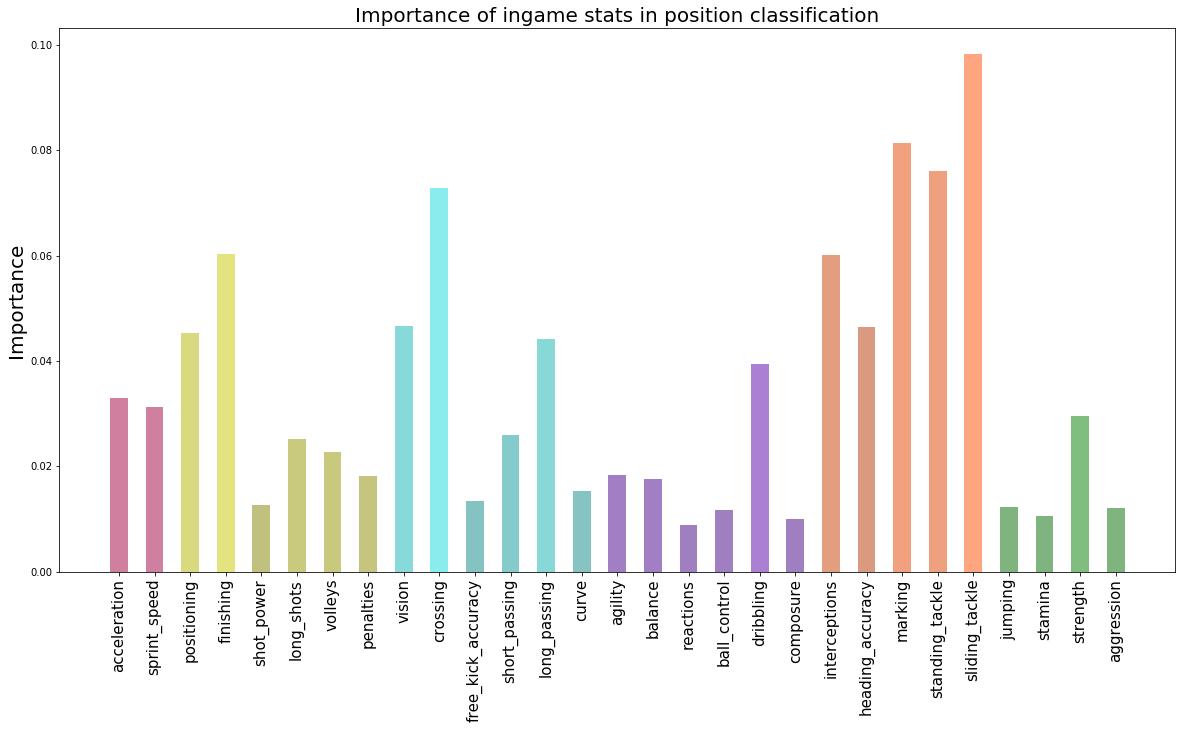

In [138]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 

width = 0.5
graph_labels = data.columns.values

fig, ax = plt.subplots(figsize=(20, 10))

ind = np.arange(len(graph_labels))
test = ax.bar(ind, rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = color_list)
ax.set_xticks(ind)
ax.set_xticklabels(graph_labels,rotation=90, fontsize=15)
ax.set_ylabel('Importance',fontsize=20)
ax.set_title('Importance of ingame stats in position classification',fontsize=20)
plt.show()

# KNN

In [139]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
parameters = {'n_neighbors':[10, 20, 30, 40, 50, 60, 70,80,90], 'weights':['uniform','distance']}
knn_clf=GridSearchCV(KNeighborsClassifier(), parameters)
knn_clf.fit(data, labels)
print(knn_clf.best_params_)
print(knn_clf.best_score_)

{'n_neighbors': 30, 'weights': 'distance'}
0.7165036997885835


In [141]:
features_train, features_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)

knn_clf=KNeighborsClassifier(n_neighbors=30, weights ='distance')
knn_clf.fit(features_train, labels_train)
pred = knn_clf.predict(features_test)
print(accuracy_score(labels_test,pred))
print(classification_report(labels_test,pred))

0.7623871393966086
             precision    recall  f1-score   support

          0       0.84      0.83      0.83       802
          1       0.77      0.78      0.77       803
          2       0.75      0.76      0.75      1362
          3       0.64      0.62      0.63       843
          4       0.83      0.85      0.84       731

avg / total       0.76      0.76      0.76      4541



### Nearest Neighbors
This simply prints out the names of the most closely related players according to the algorithm. Look up the player in the excel sheet, and plug in their index. The algorithm does need to be retrained on all the data so it has all the data points.  

In [142]:
knn_clf_2=KNeighborsClassifier(n_neighbors=30, weights ='distance')
knn_clf_2.fit(data, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

In [146]:
from IPython.display import HTML, display

player_index = 212
table = "<table><tr><td><b>{}</b></td><td><img src={}></td><td><img src={}></td><td><img src={}></td></tr></table>"

neighbors = knn_clf_2.kneighbors([data.iloc[player_index,:]],n_neighbors=5)[1]
neighbors = np.reshape(neighbors,(neighbors.shape[1]))
display(HTML(table.format(fifa.iloc[player_index,[0]].values,fifa.iloc[player_index,3],
                          fifa.iloc[player_index,1],fifa.iloc[player_index,2])))
print("--------------Neighbors--------------")

i = 1
while i<len(neighbors):
    display(HTML(table.format(fifa.iloc[neighbors[i],[0]].values,fifa.iloc[neighbors[i],3],
                              fifa.iloc[neighbors[i],1],fifa.iloc[neighbors[i],2])))
    i+=1

['G. Sigurðsson'],,,


--------------Neighbors--------------


['Cesc Fàbregas'],,,


['V. Birsa'],,,


['A. Samedov'],,,


['R. Malinovskyi'],,,
